# Installations

In [1]:
import os
os.environ["HF_HOME"] = "/media/storage/alif/huggingface"

In [2]:
# Tambahkan di awal script untuk memverifikasi partisi
import shutil

print("=== Disk Space Check ===")
print("/home free:", shutil.disk_usage("/home").free / (1024**3), "GB") 
print("/media/storage free:", shutil.disk_usage("/media/storage").free / (1024**3), "GB")

=== Disk Space Check ===
/home free: 0.023040771484375 GB
/media/storage free: 693.0065498352051 GB


In [3]:
# !pip install -q datasets
# !pip install -q bitsandbytes-cuda112
# !pip install -q bitsandbytes
# !pip install -q accelerate
# !pip install -q peft
# !pip install -q pytorch-lightning
# !pip install -q lightning[extra]
# !pip install -q transformers==4.47.0
# !pip install -q nltk rouge-score

# Load Dataset

In [4]:
from datasets import load_dataset
dataset = load_dataset("akunskripsiapillv1/indochart-v2-dataset")
dataset

DatasetDict({
    train: Dataset({
        features: ['imgname', 'query', 'label', 'image', 'source', 'chartType'],
        num_rows: 29423
    })
    validation: Dataset({
        features: ['imgname', 'query', 'label', 'image', 'source', 'chartType'],
        num_rows: 3678
    })
    test: Dataset({
        features: ['imgname', 'query', 'label', 'image', 'source', 'chartType'],
        num_rows: 3678
    })
})

In [5]:
# Filter data dengan source='bps' di setiap split
train_statista = dataset['train'].filter(lambda example: example['source'] == 'statista')
val_statista = dataset['validation'].filter(lambda example: example['source'] == 'statista')
test_statista = dataset['test'].filter(lambda example: example['source'] == 'statista')

In [6]:
print("Jumlah data training (statista):", len(train_statista))
print("Jumlah data validasi (statista):", len(val_statista))
print("Jumlah data test (statista):", len(test_statista))

Jumlah data training (statista): 19999
Jumlah data validasi (statista): 2500
Jumlah data test (statista): 2500


In [7]:
import pandas as pd
df = pd.DataFrame(train_statista)
df.groupby('chartType').size()

chartType
bar        6618
column    13055
pie         326
dtype: int64

# Load Processor & Model

In [8]:
from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig
processor = AutoProcessor.from_pretrained("ahmed-masry/ChartInstruct-LLama2")

In [9]:
import torch
USE_LORA = False
USE_QLORA = True

## Load model

# Three options for training, from the lowest precision training to the highest precision training:
# - QLora
# - Standard Lora
# - Full fine-tuning
if USE_QLORA or USE_LORA:
    if USE_QLORA:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16
        )
    model = LlavaForConditionalGeneration.from_pretrained(
        'ahmed-masry/ChartInstruct-LLama2',
        torch_dtype=torch.float16,
        quantization_config=bnb_config,
    )
else:
    # for full fine-tuning, we can speed up the model using Flash Attention
    # only available on certain devices, see https://github.com/Dao-AILab/flash-attention?tab=readme-ov-file#installation-and-features
    model = LlavaForConditionalGeneration.from_pretrained(
        'ahmed-masry/ChartInstruct-LLama2',
        torch_dtype=torch.float16,
        _attn_implementation="flash_attention_2",
    )

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

# Apply Peft

In [10]:
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model


def find_all_linear_names(model):
    cls = torch.nn.Linear
    lora_module_names = set()
    multimodal_keywords = ['multi_modal_projector', 'vision_model']
    for name, module in model.named_modules():
        if any(mm_keyword in name for mm_keyword in multimodal_keywords):
            continue
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names: # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)


lora_config = LoraConfig(
    r=8,
    lora_alpha=8,
    lora_dropout=0.1,
    target_modules=find_all_linear_names(model),
    init_lora_weights="gaussian",
)

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)

# Create Pytorch Dataset

In [11]:
from torch.utils.data import Dataset
from typing import Any, Dict
import random
from PIL import Image
from io import BytesIO

class LlavaDataset(Dataset):
    """
    PyTorch Dataset for LLaVa. This class takes a HuggingFace Dataset as input.

    Each row, consists of image path(png/jpg/jpeg) and ground truth data (json/jsonl/txt).
    """

    def __init__(self, dataset: Dataset, split: str = "train"):
        super().__init__()
        self.split = split
        self.dataset = dataset
        self.dataset_length = len(self.dataset)

    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Dict:
        """
        Returns one item of the dataset.

        Returns:
            image : the original Receipt image
            target_sequence : tokenized ground truth sequence
        """
        sample = self.dataset[idx]

        # inputs
        image = Image.open(BytesIO(sample["image"])).convert('RGB')
        if self.split == "train":
            target_sequence = f"<image>\n Question: {sample['query']} Answer: {sample['label']}"
            return image, target_sequence
        else:
            target_sequence = f"<image>\n Question: {sample['query']} Answer:"
            return image, target_sequence, sample["label"]

In [12]:
train_dataset = LlavaDataset(train_statista, split='train')
val_dataset = LlavaDataset(val_statista, split='validation')

# Define collate functions

In [13]:
def train_collate_fn(examples):
    images = []
    texts = []
    for example in examples:
        image, text = example
        images.append(image)
        texts.append(text)

    # Change the MX LENGTH depending on the task.
    MAX_LENGTH = 256
    batch = processor(text=texts, images=images, padding=True, truncation=True, max_length=MAX_LENGTH, return_tensors="pt")

    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100
    batch["labels"] = labels

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    pixel_values = batch["pixel_values"]
    labels = batch["labels"]

    return input_ids, attention_mask, pixel_values, labels


def eval_collate_fn(examples):
    # we only feed the prompt to the model
    images = []
    texts = []
    answers = []
    for example in examples:
        image, text, answer = example
        images.append(image)
        texts.append(text)
        answers.append(answer)

    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    pixel_values = batch["pixel_values"]

    return input_ids, attention_mask, pixel_values, answers

# Define Pytorch Lightening Module

In [14]:
import lightning as L
from torch.utils.data import DataLoader
import re
from nltk import edit_distance
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer


class LlavaModelPLModule(L.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model
        self.batch_size = config.get("batch_size")

        self.rouge_scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
        self.smoother = SmoothingFunction()

    def extract_numbers(self, text):
        """Extract all numbers from text as list of ints"""
        return list(map(int, re.findall(r'\d+', str(text))))

    def compute_relaxed_accuracy(self, gt_text, pred_text, tolerance=0.05):
        """Compare numbers in gt and pred with tolerance (can handle different lengths)"""
        gt_numbers = self.extract_numbers(gt_text)
        pred_numbers = self.extract_numbers(pred_text)

        matched = 0
        used_indices = set()

        for gt in gt_numbers:
            for i, pred in enumerate(pred_numbers):
                if i in used_indices:
                    continue
                if abs(gt - pred) / max(gt, 1) <= tolerance:
                    matched += 1
                    used_indices.add(i)
                    break  # Match found, move to next ground truth number

        return matched / len(gt_numbers) if gt_numbers else 1.0  # Avoid division by zero


    def training_step(self, batch, batch_idx):

        input_ids, attention_mask, pixel_values, labels = batch

        outputs = self.model(input_ids=input_ids,
                                attention_mask=attention_mask,
                                pixel_values=pixel_values,
                                labels=labels)
        loss = outputs.loss

        self.log("train_loss", loss)

        return loss

    def compute_metric(self, gt, pred):
        metrics = {}

        # 1. Relaxed Accuracy
        try:
            metrics['relaxed_acc'] = self.compute_relaxed_accuracy(gt, pred)
        except:
            metrics['relaxed_acc'] = 0.0

        # 2. BLEU Score
        try:
            reference = [str(gt).lower().split()]
            candidate = str(pred).lower().split()
            metrics['bleu'] = sentence_bleu(
                reference,
                candidate,
                smoothing_function = self.smoother.method4
            )
        except:
            metrics['bleu'] = 0.0

        # 3. ROUGE Score
        try:
            scores = self.rouge_scorer.score(str(gt).lower(), str(pred).lower())
            metrics['rougeL'] = scores['rougeL'].fmeasure
        except:
            metrics['rougeL'] = 0.0

        return metrics
            

    def validation_step(self, batch, batch_idx, dataset_idx=0):

        input_ids, attention_mask, pixel_values, answers = batch

        # autoregressively generate token IDs
        generated_ids = self.model.generate(input_ids=input_ids, attention_mask=attention_mask,
                                       pixel_values=pixel_values, max_new_tokens=256)
        # turn them back into text, chopping of the prompt
        # important: we don't skip special tokens here, because we want to see them in the output
        predictions = self.processor.batch_decode(generated_ids[:, input_ids.size(1):], skip_special_tokens=True)

        scores = {'relaxed_acc': [], 'bleu': [], 'rougeL': []}
        
        for pred, answer in zip(predictions, answers):
            pred = pred.strip()
            metric_result = self.compute_metric(answer, pred)

            for key in scores.keys():
                scores[key].append(metric_result[key])
            
            if self.config.get("verbose", False) and len(scores['relaxed_acc']) == 1:
                print(f"Prediction: {pred}")
                print(f"    Answer: {answer}")

        # Log all metrics
        self.log("val_relaxed_acc", np.mean(scores['relaxed_acc']), batch_size=self.batch_size)
        self.log("val_bleu", np.mean(scores['bleu']), batch_size=self.batch_size)
        self.log("val_rougeL", np.mean(scores['rougeL']), batch_size=self.batch_size)

        return scores

    def configure_optimizers(self):
        # you could also add a learning rate scheduler if you want
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.config.get("lr"))
        return optimizer

    def train_dataloader(self):
        return DataLoader(train_dataset, collate_fn=train_collate_fn, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(val_dataset, collate_fn=eval_collate_fn, batch_size=self.batch_size, shuffle=False, num_workers=2)

In [15]:
config = {"max_epochs": 2,
          "check_val_every_n_epoch": 1,
          "gradient_clip_val": 1.0,
          "accumulate_grad_batches": 8,
          "lr": 2e-5,
          "batch_size": 1,
          "seed":2025,
          "num_nodes": 1,
          "warmup_steps": 50,
}

model_module = LlavaModelPLModule(config, processor, model)

# Train

In [16]:
import torch
torch.set_float32_matmul_precision('medium')
!nvidia-smi

Sun Jun 15 18:38:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.05              Driver Version: 560.35.05      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:01:00.0 Off |                  N/A |
| 44%   54C    P8              9W /  350W |   11303MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [17]:
# from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
import os

# CHECKPOINT_DIR = "/media/storage/alif/checkpoints"
# os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# checkpoint_callback = ModelCheckpoint(
#     dirpath=CHECKPOINT_DIR,
#     filename="best-model-chartinstructllama-statista-v2",
#     monitor="val_relaxed_acc",
#     mode="max",
#     save_top_k=1,
#     save_last=False,
#     save_weights_only=False,
#     verbose=True,
# )

trainer = L.Trainer(
        accelerator="gpu",
        devices=[0],
        max_epochs=config.get("max_epochs"),
        accumulate_grad_batches=config.get("accumulate_grad_batches"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision="bf16-mixed",
        logger=CSVLogger(save_dir="/media/storage/alif/logs_v2"),
        # callbacks=[checkpoint_callback],
)

Using bfloat16 Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [18]:
import time

start = time.time()
trainer.fit(model_module)
end = time.time()

duration = end - start
print(f"Training time: {duration:.2f} seconds")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | PeftModel | 3.6 B  | train
--------------------------------------------
21.5 M    Trainable params
3.5 B     Non-trainable params
3.6 B     Total params
14,280.475Total estimated model params size (MB)
3472      Modules in train mode
866       Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config o

Training: |                                               | 0/? [00:00<?, ?it/s]

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config o

Validation: |                                             | 0/? [00:00<?, ?it/s]

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config o

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


Training time: 60030.92 seconds


In [21]:
# # Save Model locally
# model_module.model.save_pretrained('trained_model_indochart_v2')
# model_module.processor.save_pretrained('trained_model_indochart_v2')

['trained_model_statista/processor_config.json']

In [ ]:
from huggingface_hub import create_repo, login

hf_token="HF_TOKEN"
login(hf_token)

# Define model and processor
model = model_module.model
processor = model_module.processor

# Define the repository name where you want to upload the model
repo_name = "akunskripsiapillv1/finetuned-chartinstruct-llama2-statista-v2"

# Create the repo (if it doesn't exist)
create_repo(repo_name, exist_ok=True)

# Push model and processor to Hugging Face Hub
model.push_to_hub(repo_name)
processor.push_to_hub(repo_name)

adapter_model.safetensors:   0%|          | 0.00/86.0M [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/akunskripsiapillv1/finetuned-chartinstruct-llama2-statista-v2/commit/652343dcad9a731a9c798282f54ae9e8e5fe6485', commit_message='Upload processor', commit_description='', oid='652343dcad9a731a9c798282f54ae9e8e5fe6485', pr_url=None, repo_url=RepoUrl('https://huggingface.co/akunskripsiapillv1/finetuned-chartinstruct-llama2-statista-v2', endpoint='https://huggingface.co', repo_type='model', repo_id='akunskripsiapillv1/finetuned-chartinstruct-llama2-statista-v2'), pr_revision=None, pr_num=None)

# Inference

Let's see if the model has learned something. We'll load the model from the hub first. Notice that, as we only trained adapters on top of the base model, the repository on the hub to which we pushed only contains the weights and configuration of the adapters. This is a very lightweight file smaller than 100 MB.

Thanks to the PEFT integration in Transformers, the from_pretrained method will automatically load the weights of the base model as well as the adapter weights.

To reduce inference costs, we'll again load the model in 4 bits by passing a quantization_config, in order to reduce memory usage.

In [20]:
from transformers import AutoProcessor, BitsAndBytesConfig, LlavaForConditionalGeneration
import torch

processor = AutoProcessor.from_pretrained('akunskripsiapillv1/finetuned-chartinstruct-llama2-statista-v2')

# Define quantization config
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16
)
# Load the base model with adapters on top
model = LlavaForConditionalGeneration.from_pretrained(
    'akunskripsiapillv1/finetuned-chartinstruct-llama2-statista-v2',
    torch_dtype=torch.float16,
    quantization_config=quantization_config,
)

adapter_config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/86.0M [00:00<?, ?B/s]

In [21]:
# Load example
from PIL import Image
from io import BytesIO

sample_idx = 0
query = test_statista[sample_idx]['query']

test_image = Image.open(BytesIO(test_statista[sample_idx]['image'])).convert('RGB')
prompt = f"<image>\n Question: {query} Answer:"
inputs = processor(text=prompt, images=[test_image], return_tensors="pt").to("cuda")
inputs['pixel_values'] = inputs['pixel_values'].to(torch.float16)

# Generate token IDs. Change the max_new_tokens based on your task.
generated_ids = model.generate(**inputs, max_new_tokens=256)
# Decode back into text
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.


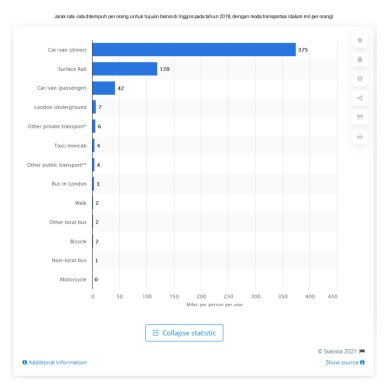

['\n Question: Buatkan deskripsi dari grafik berikut ini secara lengkap dan informatif Answer: Statistik ini menunjukkan jenis mobil yang digunakan oleh pengemudi yang mengemudi di Inggris pada tahun 2018, dengan jumlah mil per jam yang ditempuh. Ditemukan bahwa mobil penumpang yang paling digunakan oleh pengemudi yang mengemudi adalah car-van, dengan rata-rata 375 mil per jam. Mobil penumpang lainnya yang paling digunakan oleh pengemudi yang mengemudi adalah surfis rai, dengan rata-rata 120 mil per jam. Mobil penumpang lainnya yang paling digunakan oleh pengemudi yang mengemudi adalah car-van, dengan rata-rata 42 mil per jam. Pada tahun 2018, sekitar 20 persen dari semua pengemudi yang mengemudi di Inggr']


In [22]:
import matplotlib.pyplot as plt

plt.imshow(test_image)
plt.axis('off')  # Hilangkan axis
plt.show()


print(generated_texts)

In [23]:
# Ground truth answer
print(test_statista[sample_idx]['label'])

Statistik ini membandingkan jarak rata-rata yang ditempuh per orang setiap tahun untuk tujuan bisnis di Inggris pada tahun 2018, dengan moda transportasi. Perjalanan Surface Rail berada di posisi kedua, dengan rata-rata 120 mil yang ditempuh per orang per tahun untuk tujuan bisnis.


In [24]:
# Load example
from PIL import Image
from io import BytesIO

sample_idx = 11
query = test_statista[sample_idx]['query']

test_image = Image.open(BytesIO(test_statista[sample_idx]['image'])).convert('RGB')
prompt = f"<image>\n Question: {query} Answer:"
inputs = processor(text=prompt, images=[test_image], return_tensors="pt").to("cuda")
inputs['pixel_values'] = inputs['pixel_values'].to(torch.float16)

# Generate token IDs. Change the max_new_tokens based on your task.
generated_ids = model.generate(**inputs, max_new_tokens=256)
# Decode back into text
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

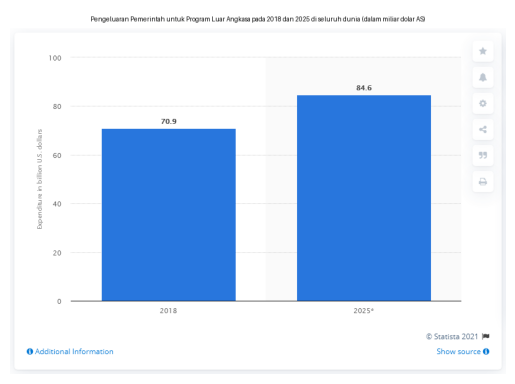

['\n Question: Buatkan deskripsi dari grafik berikut ini secara lengkap dan informatif Answer: Statistik ini menunjukkan pengeluaran pemerintah untuk program pemerintahan laut Angkatan Laut A.S. pada tahun fiskal 2018 dan 2025. Pada tahun 2018, pemerintah AS menghabiskan sekitar 70,9 miliar dolar AS untuk program pemerintahan laut. Pada tahun 2025, pemerintah AS diproyeksikan menghabiskan sekitar 84,6 miliar dolar AS untuk program pemerintahan laut. Program pemerintahan laut A.S. termasuk pengeluaran untuk kapal pengawal, kapal penyedia layanan, dan pengeluaran untuk pengawalan dan pengawalan. Kapal pengawalan A.S. memiliki kapasitas sekitar 3.700. Kapal penyedia layanan A.S. memil']


In [25]:
import matplotlib.pyplot as plt

plt.imshow(test_image)
plt.axis('off')  # Hilangkan axis
plt.show()


print(generated_texts)

In [26]:
# Ground truth answer
print(test_statista[sample_idx]['label'])

Statistik ini menunjukkan pengeluaran program ruang pemerintah global pada tahun 2018 dan memberikan perkiraan untuk tahun 2025. Pada tahun 2018, pengeluaran pemerintah untuk program luar angkasa di seluruh dunia berjumlah 70,9 miliar dolar AS. Amerika Serikat adalah pemboros terkemuka di tahun itu.


In [27]:
# Load example
from PIL import Image
from io import BytesIO

sample_idx = 111
query = test_statista[sample_idx]['query']

test_image = Image.open(BytesIO(test_statista[sample_idx]['image'])).convert('RGB')
prompt = f"<image>\n Question: {query} Answer:"
inputs = processor(text=prompt, images=[test_image], return_tensors="pt").to("cuda")
inputs['pixel_values'] = inputs['pixel_values'].to(torch.float16)

# Generate token IDs. Change the max_new_tokens based on your task.
generated_ids = model.generate(**inputs, max_new_tokens=256)
# Decode back into text
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

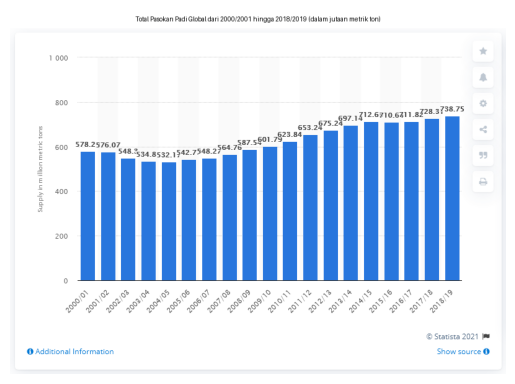

['\n Question: Buatkan deskripsi dari grafik berikut ini secara lengkap dan informatif Answer: Statistik ini menunjukkan total pasokan padi global dari tahun 2000 hingga 2019. Pada tahun 2019, total pasokan padi global berjumlah sekitar 738,75 juta metrik ton. Padi adalah jenis buah yang diproduksi dari pohon padi. Padi adalah salah satu jenis buah yang paling banyak diproduksi di dunia. Padi digunakan untuk makanan, minuman, dan bahan baku untuk produksi tekstil. Padi juga digunakan sebagai bahan baku untuk produksi bahan bakar bensin. Padi juga digunakan sebagai bahan bakar bensin. Padi juga digunakan sebagai bahan bakar bensin. Padi juga digunakan sebagai bahan bakar bensin. Padi juga dig']


In [28]:
import matplotlib.pyplot as plt

plt.imshow(test_image)
plt.axis('off')  # Hilangkan axis
plt.show()

print(generated_texts)

In [29]:
# Ground truth answer
print(test_statista[sample_idx]['label'])

Statistik ini menggambarkan total pasokan padi di seluruh dunia dari 2000/2001 hingga 2018/2019, diukur dalam juta metrik ton setara yang digiling. Pada 2018/2019, total pasokan global beras berjumlah sekitar 738,75 juta metrik ton.


In [30]:
# Load example
from PIL import Image
from io import BytesIO

sample_idx = 1111
query = test_statista[sample_idx]['query']

test_image = Image.open(BytesIO(test_statista[sample_idx]['image'])).convert('RGB')
prompt = f"<image>\n Question: {query} Answer:"
inputs = processor(text=prompt, images=[test_image], return_tensors="pt").to("cuda")
inputs['pixel_values'] = inputs['pixel_values'].to(torch.float16)

# Generate token IDs. Change the max_new_tokens based on your task.
generated_ids = model.generate(**inputs, max_new_tokens=256)
# Decode back into text
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

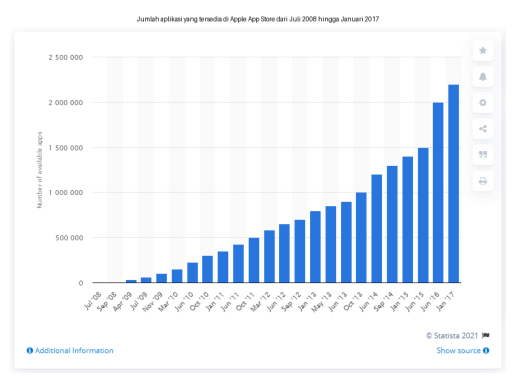

['\n Question: Buatkan deskripsi dari grafik berikut ini secara lengkap dan informatif Answer: Statistik ini menunjukkan jumlah aplikasi yang tersedia di Apple App Store dari Juli 2008 hingga Januari 2017. Pada Januari 2017, ada sekitar 2,2 juta aplikasi yang tersedia di Apple App Store. Apple App Store adalah layanan unduhan aplikasi yang dikembangkan oleh Apple Inc. dan dirilis pada tahun 2008. Pada tahun 2011, Apple mengumumkan bahwa 100.000 aplikasi telah diunduhan sekitar 100 juta kali. Pada tahun 2016, Apple mengumumkan bahwa 200.000 aplikasi telah diunduhan sekitar 200 juta kali. Apple App Store adalah salah satu platform unduhan aplikasi terkemuka di dunia. Pada tahun 2016, Apple App Store']


In [31]:
import matplotlib.pyplot as plt

plt.imshow(test_image)
plt.axis('off')  # Hilangkan axis
plt.show()

print(generated_texts)

In [32]:
# Ground truth answer
print(test_statista[sample_idx]['label'])

Statistik ini memberikan informasi tentang jumlah aplikasi yang tersedia di Apple App Store sejak Juli 2008. Pada Januari 2017, 2,2 juta aplikasi seluler tersedia untuk diunduh untuk berbagai perangkat iOS.
